# Integrating data using ingest and BBKNN

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns

In [2]:
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')

-----
anndata     0.10.2
scanpy      1.9.5
-----
CoreFoundation      NA
Foundation          NA
PIL                 9.4.0
PyObjCTools         NA
anyio               NA
appnope             0.1.2
arrow               1.2.3
asttokens           NA
attr                22.1.0
babel               2.11.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.5
brotli              NA
certifi             2023.07.22
cffi                1.15.1
chardet             4.0.0
charset_normalizer  2.0.4
cloudpickle         2.2.1
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.0
dask                2023.6.0
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml          0.7.1
dill                0.3.6
entrypoints         0.4
executing           0.8.3
fastjsonschema      NA
fqdn                NA
gmpy2               2.1.2
h5py                3.7.0
hypergeom_u

## PBMCs

In [3]:
adata_ref = sc.datasets.pbmc3k_processed()  # this is an earlier version of the dataset from the pbmc3k tutorial
adata = sc.datasets.pbmc68k_reduced()

In [4]:
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

In [5]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


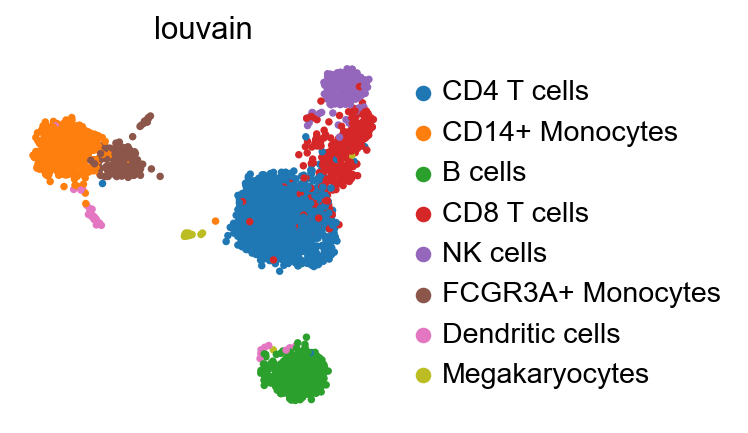

In [6]:
sc.pl.umap(adata_ref, color='louvain')

### Mapping PBMCs using ingest

In [7]:
sc.tl.ingest(adata, adata_ref, obs='louvain')

/Users/cjerry/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['rep']` of view, initializing view as actual.
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.


In [8]:
adata.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix colors

/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


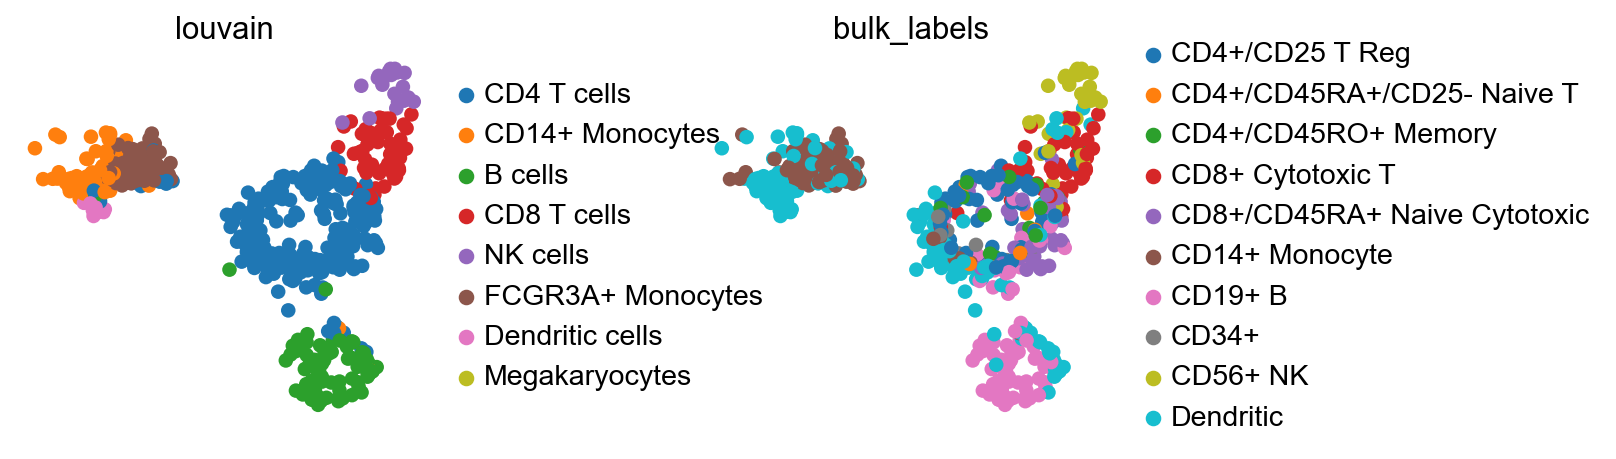

In [9]:
sc.pl.umap(adata, color=['louvain', 'bulk_labels'], wspace=0.5)

In [10]:
adata_concat = adata_ref.concatenate(adata, batch_categories=['ref', 'new'])

/Users/cjerry/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1823: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [11]:
adata_concat.obs.louvain = adata_concat.obs.louvain.astype('category')
adata_concat.obs.louvain.cat.reorder_categories(adata_ref.obs.louvain.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix category colors

/var/folders/w_/jfhkzbcx6311zqlbnq7j9mm80000gn/T/ipykernel_36937/2341824880.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_concat.obs.louvain.cat.reorder_categories(adata_ref.obs.louvain.cat.categories, inplace=True)  # fix category ordering


/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


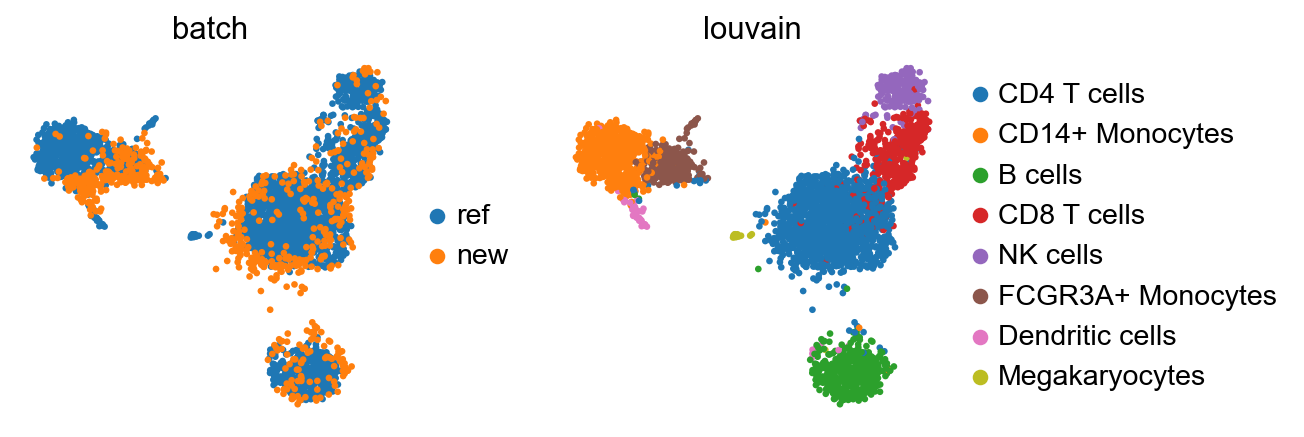

In [12]:
sc.pl.umap(adata_concat, color=['batch', 'louvain'])

### Using BBKNN

In [13]:
sc.tl.pca(adata_concat)

In [14]:
%%time
sc.external.pp.bbknn(adata_concat, batch_key='batch')  # running bbknn 1.3.6

CPU times: user 903 ms, sys: 597 ms, total: 1.5 s
Wall time: 200 ms


In [15]:
sc.tl.umap(adata_concat)

/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


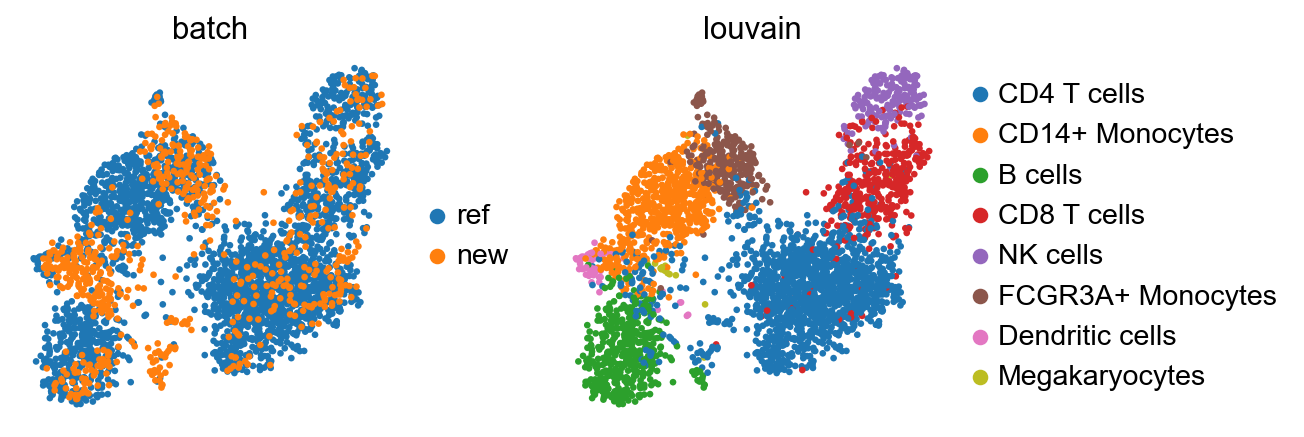

In [16]:
sc.pl.umap(adata_concat, color=['batch', 'louvain'])

## Pancreas

In [17]:
# note that this collection of batches is already intersected on the genes
adata_all = sc.read('data/pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')

  0%|          | 0.00/176M [00:00<?, ?B/s]

/Users/cjerry/anaconda3/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/cjerry/anaconda3/lib/python3.11/site-packages/anndata/compat/__init__.py:298: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/cjerry/anaconda3/lib/python3.11/site-packages/anndata/compat/__init__.py:298: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [18]:
adata_all.shape

(14693, 2448)

Inspect the cell types observed in these studies.

In [19]:
counts = adata_all.obs.celltype.value_counts()
counts

alpha                     4214
beta                      3354
ductal                    1804
acinar                    1368
not applicable            1154
delta                      917
gamma                      571
endothelial                289
activated_stellate         284
dropped                    178
quiescent_stellate         173
mesenchymal                 80
macrophage                  55
PSC                         54
unclassified endocrine      41
co-expression               39
mast                        32
epsilon                     28
mesenchyme                  27
schwann                     13
t_cell                       7
MHC class II                 5
unclear                      4
unclassified                 2
Name: celltype, dtype: int64

In [20]:
minority_classes = counts.index[-5:].tolist()        # get the minority classes
adata_all = adata_all[                               # actually subset
    ~adata_all.obs.celltype.isin(minority_classes)]
adata_all.obs.celltype.cat.reorder_categories(       # reorder according to abundance 
    counts.index[:-5].tolist(), inplace=True)  

/var/folders/w_/jfhkzbcx6311zqlbnq7j9mm80000gn/T/ipykernel_36937/2578860003.py:4: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_all.obs.celltype.cat.reorder_categories(       # reorder according to abundance


### Seeing the batch effect

In [21]:
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)

/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


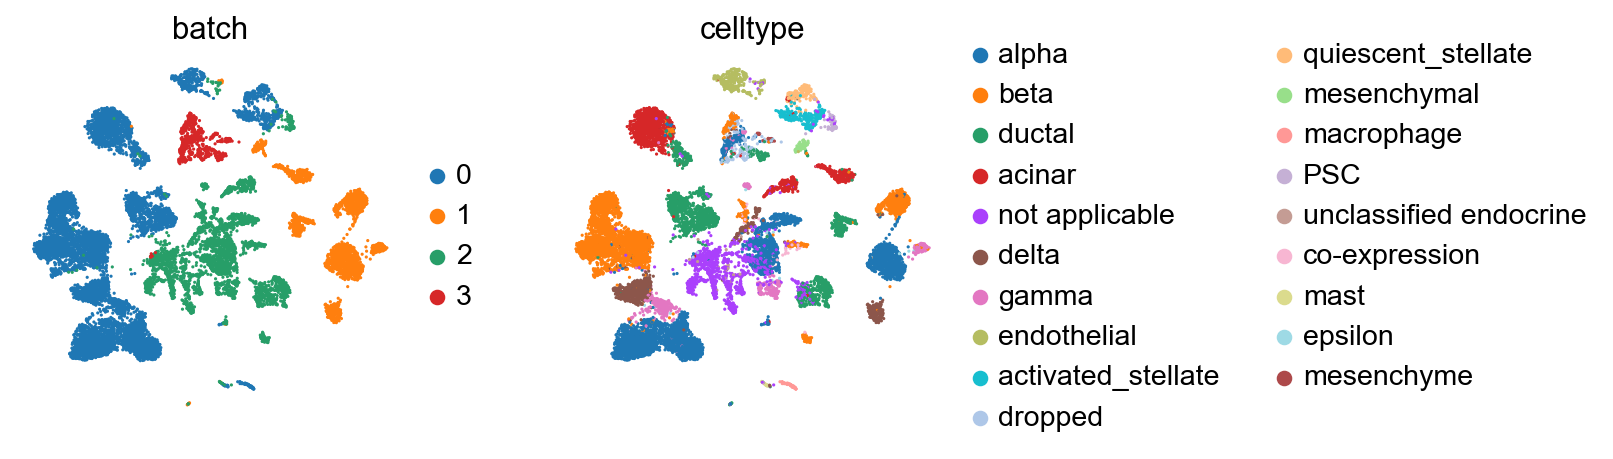

In [22]:
sc.pl.umap(adata_all, color=['batch', 'celltype'], palette=sc.pl.palettes.vega_20_scanpy)

### BBKNN

In [23]:
%%time
sc.external.pp.bbknn(adata_all, batch_key='batch')

CPU times: user 1 s, sys: 9.39 ms, total: 1.01 s
Wall time: 650 ms


In [24]:
sc.tl.umap(adata_all)

/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


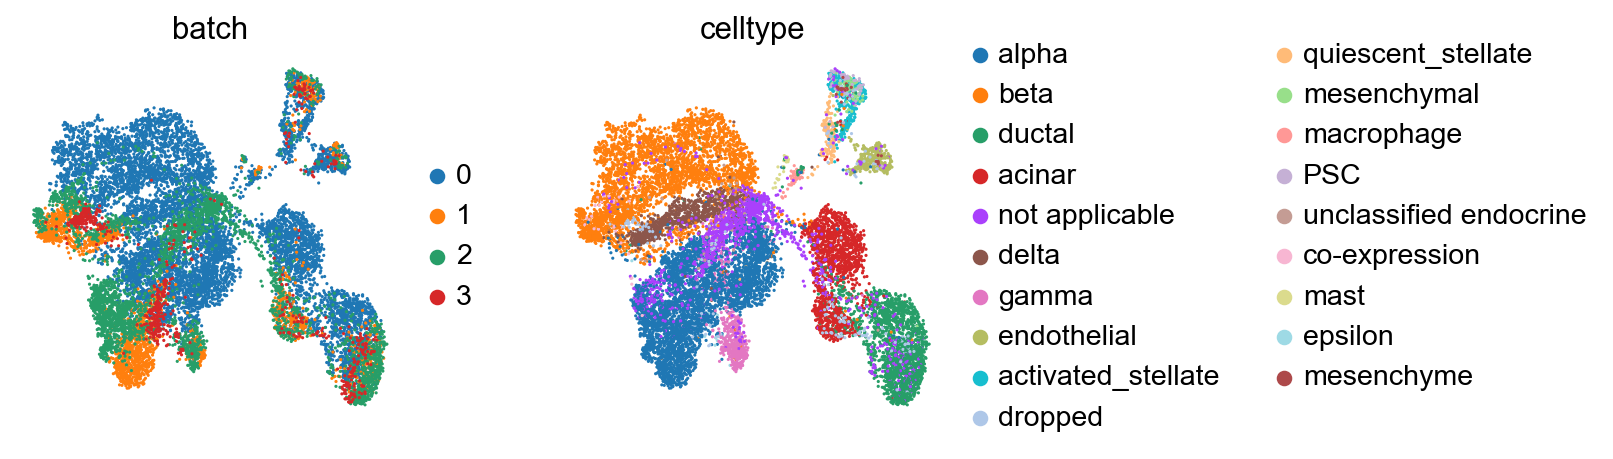

In [25]:
sc.pl.umap(adata_all, color=['batch', 'celltype'])

### Mapping onto a reference batch using ingest

In [26]:
adata_ref = adata_all[adata_all.obs.batch == '0']

In [27]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


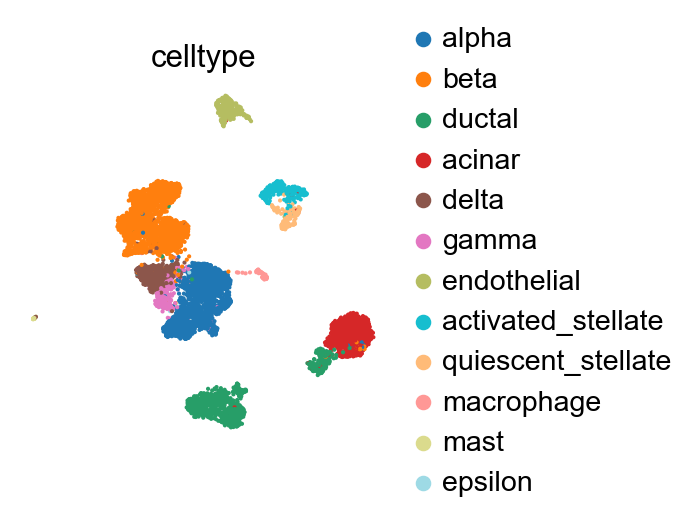

In [28]:
sc.pl.umap(adata_ref, color='celltype')

In [29]:
adatas = [adata_all[adata_all.obs.batch == i].copy() for i in ['1', '2', '3']]

In [30]:
sc.settings.verbosity = 2  # a bit more logging
for iadata, adata in enumerate(adatas):
    print(f'... integrating batch {iadata+1}')
    adata.obs['celltype_orig'] = adata.obs.celltype  # save the original cell type
    sc.tl.ingest(adata, adata_ref, obs='celltype')

... integrating batch 1
running ingest


/Users/cjerry/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:01)
... integrating batch 2
running ingest


/Users/cjerry/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:02)
... integrating batch 3
running ingest


/Users/cjerry/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:01)


In [31]:
adata_concat = adata_ref.concatenate(adatas)

/Users/cjerry/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1823: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [32]:
adata_concat.obs.celltype = adata_concat.obs.celltype.astype('category')
adata_concat.obs.celltype.cat.reorder_categories(adata_ref.obs.celltype.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['celltype_colors'] = adata_ref.uns['celltype_colors']  # fix category coloring

/var/folders/w_/jfhkzbcx6311zqlbnq7j9mm80000gn/T/ipykernel_36937/1749108536.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_concat.obs.celltype.cat.reorder_categories(adata_ref.obs.celltype.cat.categories, inplace=True)  # fix category ordering


/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


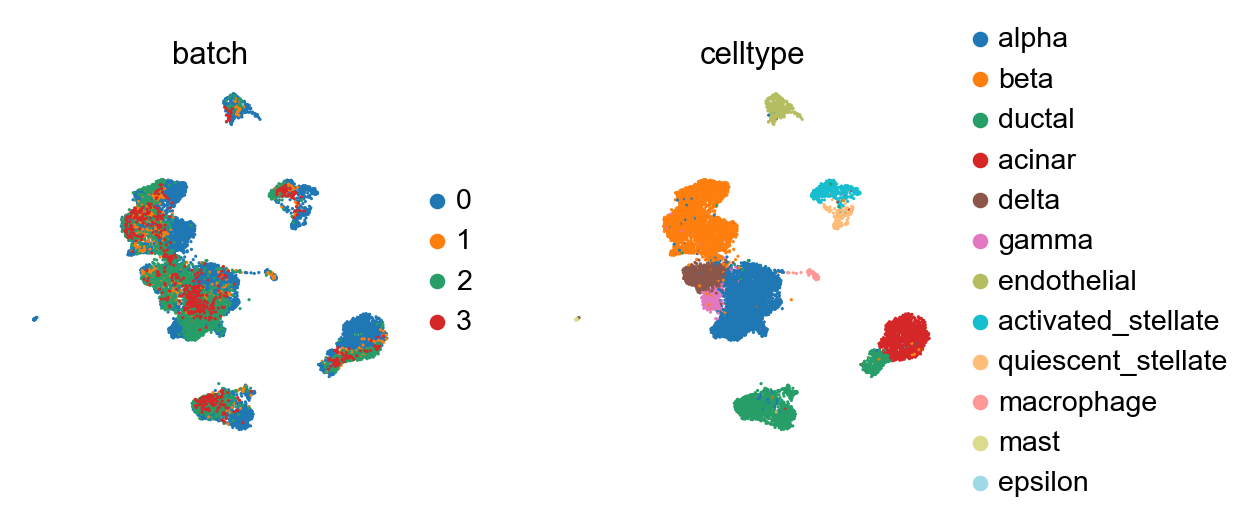

In [33]:
sc.pl.umap(adata_concat, color=['batch', 'celltype'])

### Evaluating consistency

In [34]:
adata_query = adata_concat[adata_concat.obs.batch.isin(['1', '2', '3'])]

/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


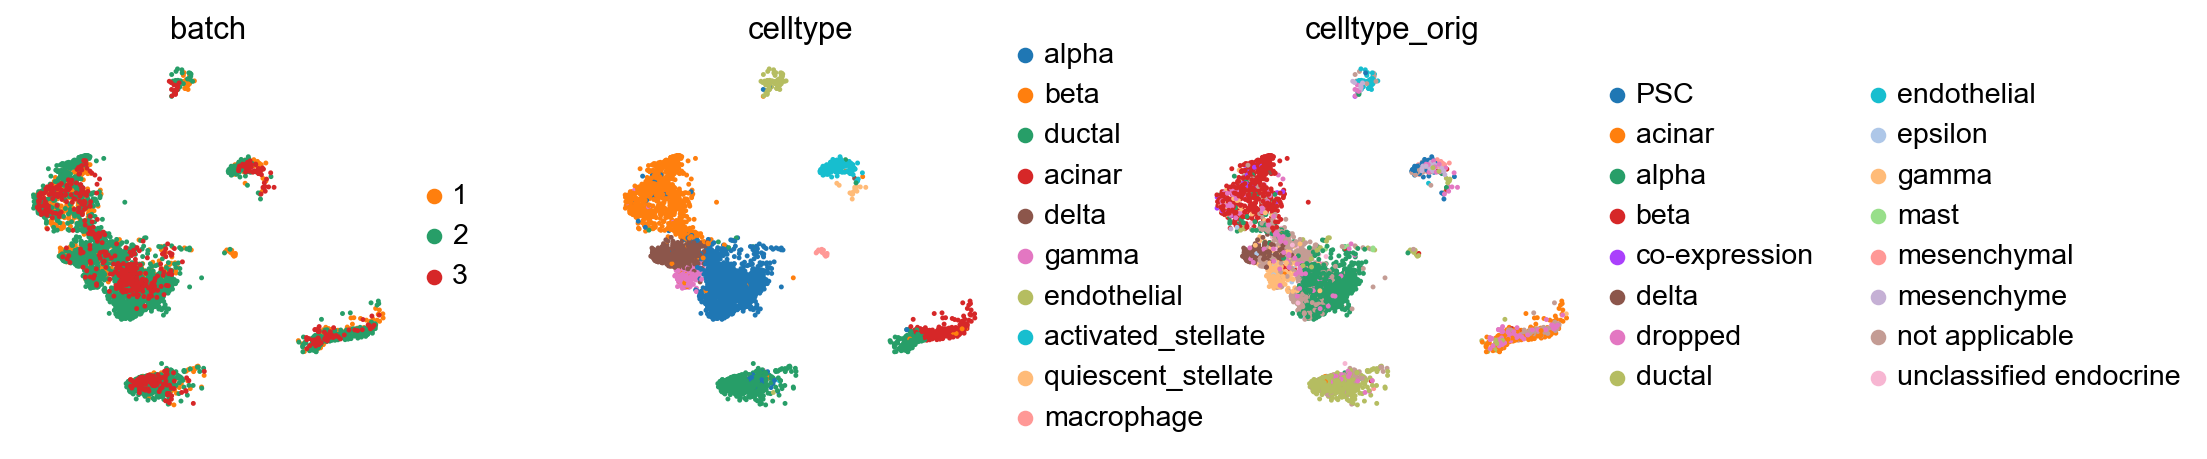

In [35]:
sc.pl.umap(
    adata_query, color=['batch', 'celltype', 'celltype_orig'], wspace=0.4)

#### Cell types conserved across batches

In [36]:
obs_query = adata_query.obs
conserved_categories = obs_query.celltype.cat.categories.intersection(obs_query.celltype_orig.cat.categories)  # intersected categories
obs_query_conserved = obs_query.loc[obs_query.celltype.isin(conserved_categories) & obs_query.celltype_orig.isin(conserved_categories)]  # intersect categories
obs_query_conserved.celltype.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
obs_query_conserved.celltype_orig.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
obs_query_conserved.celltype_orig.cat.reorder_categories(obs_query_conserved.celltype.cat.categories, inplace=True)  # fix category ordering

/var/folders/w_/jfhkzbcx6311zqlbnq7j9mm80000gn/T/ipykernel_36937/2750919581.py:4: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  obs_query_conserved.celltype.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
/var/folders/w_/jfhkzbcx6311zqlbnq7j9mm80000gn/T/ipykernel_36937/2750919581.py:5: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  obs_query_conserved.celltype_orig.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
/var/folders/w_/jfhkzbcx6311zqlbnq7j9mm80000gn/T/ipykernel_36937/2750919581.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  obs_query_conserved.celltype_orig.cat.reorder_categories(

In [37]:
pd.crosstab(obs_query_conserved.celltype, obs_query_conserved.celltype_orig)

celltype_orig,alpha,beta,ductal,acinar,delta,gamma,endothelial
celltype,,,,,,,
alpha,1814,3,19,0,1,20,0
beta,54,806,5,1,10,37,0
ductal,6,5,680,242,0,0,0
acinar,2,3,3,165,0,3,0
delta,6,3,1,0,305,72,0
gamma,1,5,0,1,0,184,0
endothelial,2,0,0,0,0,0,36


#### All cell types

In [38]:
pd.crosstab(adata_query.obs.celltype, adata_query.obs.celltype_orig)

celltype_orig,PSC,acinar,alpha,beta,co-expression,delta,dropped,ductal,endothelial,epsilon,gamma,mast,mesenchymal,mesenchyme,not applicable,unclassified endocrine
celltype,,,,,,,,,,,,,,,,
alpha,0,0,1814,3,3,1,40,19,0,3,20,7,0,0,310,9
beta,1,1,54,806,36,10,42,5,0,0,37,0,0,1,522,24
ductal,0,242,6,5,0,0,37,680,0,0,0,0,2,0,95,1
acinar,0,165,2,3,0,0,23,3,0,0,3,0,0,0,90,0
delta,0,0,6,3,0,305,13,1,0,6,72,0,0,0,96,7
gamma,0,1,1,5,0,0,1,0,0,1,184,0,0,0,15,0
endothelial,1,0,2,0,0,0,6,0,36,0,0,0,0,6,7,0
activated_stellate,48,1,1,2,0,0,11,6,0,0,0,0,78,20,17,0
quiescent_stellate,4,0,1,1,0,0,5,1,1,0,0,0,0,0,1,0


### Visualizing distributions across batches

#### Density plot

In [39]:
sc.tl.embedding_density(adata_concat, groupby='batch')

computing density on 'umap'


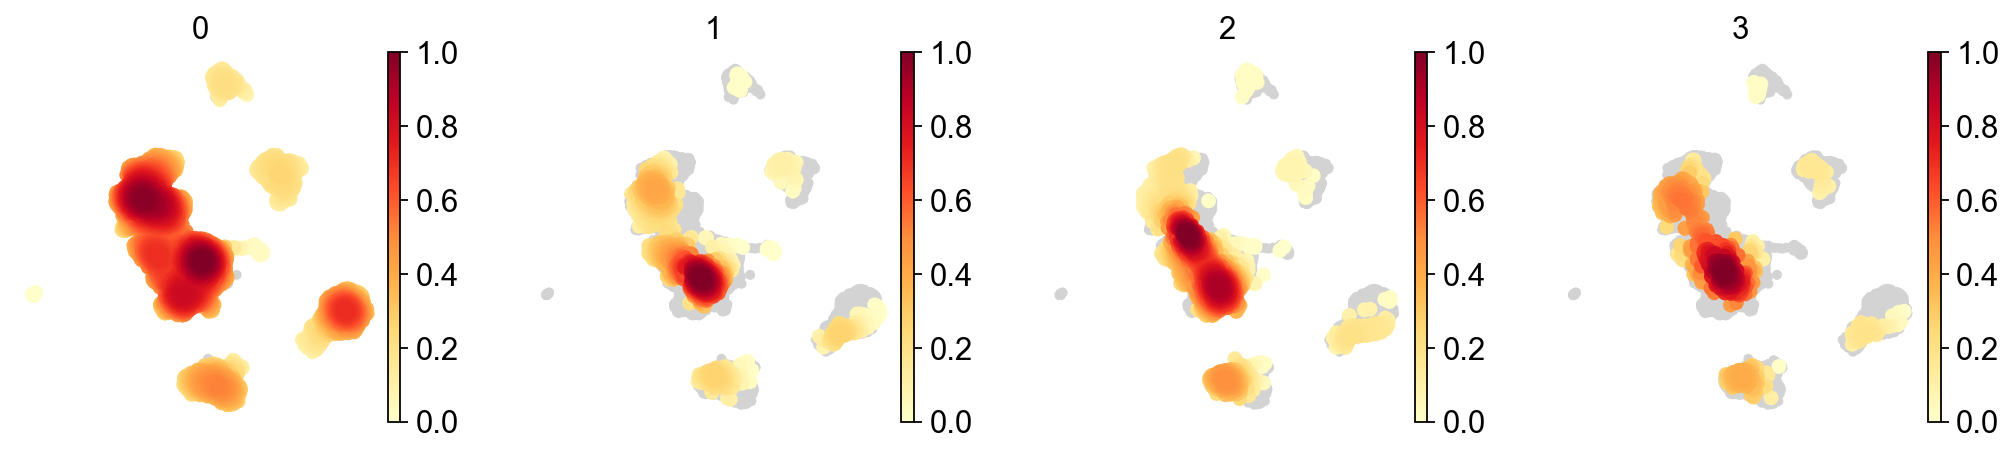

In [40]:
sc.pl.embedding_density(adata_concat, groupby='batch')

#### Partial visualizaton of a subset of groups in embedding

/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


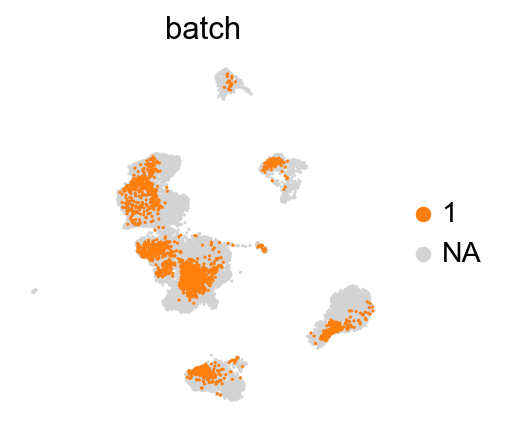

/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


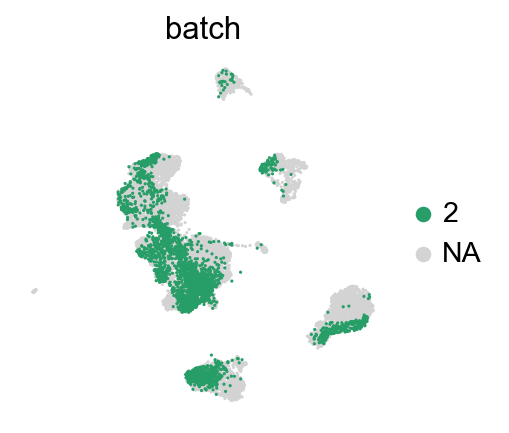

/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


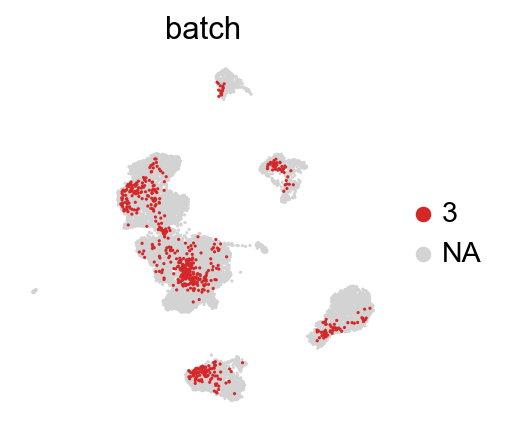

In [41]:
for batch in ['1', '2', '3']:
    sc.pl.umap(adata_concat, color='batch', groups=[batch])